In [1]:
from gp import *
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import importlib
import gp
importlib.reload(gp)
from gp import *
import matplotlib.pyplot as plt


# Dataset characteristics<br>
- instant: record index<br>
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month (1 to 12)
- hr : hour (0 to 23)
- holiday : whether day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In [3]:
import pandas as pd

df = pd.read_csv("hour.csv")
df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


# Data Preprocess

In [4]:
reference_date = pd.Timestamp('2011-01-01')
df.iloc[:, 1] = (pd.to_datetime(df.iloc[:, 1]) - reference_date).dt.days
data = df.to_numpy(dtype=float)
data

array([[1.0000e+00, 0.0000e+00, 1.0000e+00, ..., 3.0000e+00, 1.3000e+01,
        1.6000e+01],
       [2.0000e+00, 0.0000e+00, 1.0000e+00, ..., 8.0000e+00, 3.2000e+01,
        4.0000e+01],
       [3.0000e+00, 0.0000e+00, 1.0000e+00, ..., 5.0000e+00, 2.7000e+01,
        3.2000e+01],
       ...,
       [1.7377e+04, 7.3000e+02, 1.0000e+00, ..., 7.0000e+00, 8.3000e+01,
        9.0000e+01],
       [1.7378e+04, 7.3000e+02, 1.0000e+00, ..., 1.3000e+01, 4.8000e+01,
        6.1000e+01],
       [1.7379e+04, 7.3000e+02, 1.0000e+00, ..., 1.2000e+01, 3.7000e+01,
        4.9000e+01]])

In [5]:
X_whole = data[:, 1:14] # the first column is index, not necessary
Y_whole = data[:, 16] # count of total rental bikes as label
X_whole 

array([[0.000e+00, 1.000e+00, 0.000e+00, ..., 2.879e-01, 8.100e-01,
        0.000e+00],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 2.727e-01, 8.000e-01,
        0.000e+00],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 2.727e-01, 8.000e-01,
        0.000e+00],
       ...,
       [7.300e+02, 1.000e+00, 1.000e+00, ..., 2.576e-01, 6.000e-01,
        1.642e-01],
       [7.300e+02, 1.000e+00, 1.000e+00, ..., 2.727e-01, 5.600e-01,
        1.343e-01],
       [7.300e+02, 1.000e+00, 1.000e+00, ..., 2.727e-01, 6.500e-01,
        1.343e-01]])

In [6]:
def standardize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X-mean)/std, mean, std

def split_train_test(X_whole, Y_whole, num=1500, rate=0.7):
    # Shuffle data first
    indices = jax.random.permutation(grab_prng(), X_whole.shape[0])
    X_part = X_whole[indices]
    Y_part = Y_whole[indices]
    
    indices = jax.random.permutation(grab_prng(), num)
    X_shuffled = X_part[indices]
    Y_shuffled = Y_part[indices]
    
    # Standardize the shuffled data
    X, mean, std = standardize(X_shuffled)
    Y, mean, std = standardize(Y_shuffled)

    # Use the same indices for Y
    # Y = Y_shuffled
    
    # Compute the split index
    split_idx = int(num * rate)
    
    # Split indices into train and test
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]
    
    # Split data using the indices
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    
    return X_train, Y_train, X_test, Y_test


In [7]:
def split_clml(X_train, Y_train, ratio=0.8):
    n_samples = X_train.shape[0]
    indices = jax.random.permutation(grab_prng(), n_samples)
    # Shuffle the data
    X_train_shuffled = X_train[indices]
    Y_train_shuffled = Y_train[indices]
    
    # Calculate the base size of each subset
    subset_size = int(n_samples * ratio)
    
    # Initialize lists to hold the subsets
    X_con = [X_train_shuffled[:subset_size], X_train_shuffled[subset_size:]]
    Y_con = [Y_train_shuffled[:subset_size], Y_train_shuffled[subset_size:]]
    
    return X_con, Y_con

def split_sequence(X_train, Y_train, seq_len=8):
    n_samples = X_train.shape[0]
    indices = jax.random.permutation(grab_prng(), n_samples)
     # Shuffle the data
    X_train_shuffled = X_train[indices]
    Y_train_shuffled = Y_train[indices]
    
    # Calculate the base size of each subset
    subset_size = n_samples // seq_len
    remainder = n_samples % seq_len
    
    # Initialize lists to hold the subsets
    X_seq = []
    Y_seq = []
    
    start_idx = 0
    for i in range(seq_len):
        # The first subset gets the remainder (extra) samples
        if i == 0:
            end_idx = start_idx + subset_size + remainder
        else:
            end_idx = start_idx + subset_size
        
        X_seq.append(X_train_shuffled[start_idx:end_idx])
        Y_seq.append(Y_train_shuffled[start_idx:end_idx])
        
        start_idx = end_idx
    return X_seq, Y_seq

# Plotting code

In [ ]:
def scatterplot(lml_lpd, label_x, label_y, tit):
    plt.scatter(lml_lpd[:,0], lml_lpd[:,1])
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.title(tit)
    plt.legend()
    plt.show()
#

def plot_comparision(lml, clml, clmls):
    plt.scatter(range(len(lml)), lml, label="LML", color="red", marker="o")
    plt.scatter(range(len(clml)), clml, label="CLML", color="blue", marker="x")
    plt.scatter(range(len(clmls)), clmls, label="CLMLS", color="green", marker="s")

    plt.xlabel("Hyperparameter Setting Index")
    plt.ylabel("NLPD")
    plt.title("Comparison Between Different Generalization Metrics")
    plt.legend()
    plt.show()
#

# Experiment 2 - feature importance using learned Mahalanobis distances

In [9]:
def random_init_sqexp_maha_hyperparams(X_train):
    var = jax.random.uniform(grab_prng(), shape=(2,), minval=0.2, maxval=2)
    length_scale = jax.random.uniform(grab_prng(), shape=(X_train.shape[1],), minval=1, maxval=10)
    return np.concatenate([var, length_scale])

def lml_exp(hyperparams_inits, T=200, step_size=1e-4):
    lml_trials = []
    opt_hyperparams = []
    for n in range(n_trials):
        hyperparams_init = hyperparams_inits[n]
        unconstrained_hyperparams_init = inverse_param_transform(hyperparams_init)
        (unconstrained_hyperparams, lml) = empirical_bayes(cov_func, X_train, Y_train, unconstrained_hyperparams_init, step_size, T)
        hyperparams = param_transform(unconstrained_hyperparams)
        
        posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams_init)
        (posterior_mean, posterior_var) = posterior_predictive(X_star)
        neg_log_initial = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams_init[0])

        posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams)
        (posterior_mean, posterior_var) = posterior_predictive(X_star)
        neg_log_final = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams[0])
        print(np.array([neg_log_initial, neg_log_final, lml]))
        lml_trials.append(np.array([neg_log_initial, neg_log_final, lml]))
        opt_hyperparams.append(hyperparams)
    # #
    trials_array = np.array(lml_trials)
    lml_nlpd = np.column_stack((trials_array[:, 2], trials_array[:, 1]))
    return lml_nlpd, opt_hyperparams

def clml_exp(hyperparams_inits, T=200, step_size=1e-3):
    clml_trials = []
    opt_hyperparams = []
    for n in range(n_trials):
        hyperparams_init = hyperparams_inits[n]
        unconstrained_hyperparams_init = inverse_param_transform(hyperparams_init)
        (unconstrained_hyperparams, clml) = clml_opt(cov_func, X_con, Y_con, unconstrained_hyperparams_init, step_size, T)
        hyperparams = param_transform(unconstrained_hyperparams)

        posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams_init)
        (posterior_mean, posterior_var) = posterior_predictive(X_star)
        neg_log_initial = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams_init[0])

        posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams)
        (posterior_mean, posterior_var) = posterior_predictive(X_star)
        neg_log_final = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams[0])
        print(np.array([neg_log_initial, neg_log_final, clml]))
        clml_trials.append(np.array([neg_log_initial, neg_log_final, clml]))
        opt_hyperparams.append(hyperparams)

    #
    trials_array = np.array(clml_trials)
    clml_nlpd = np.column_stack((trials_array[:, 2], trials_array[:, 1]))
    return clml_nlpd, opt_hyperparams

def clmls_exp(hyperparams_inits, T=200, step_size=5e-3):
    clmls_trials = []
    opt_hyperparams = []
    for n in range(n_trials):
        hyperparams_init = hyperparams_inits[n]
        unconstrained_hyperparams_init = inverse_param_transform(hyperparams_init)
        (unconstrained_hyperparams, clmls) = clmls_opt(cov_func, X_seq, Y_seq, unconstrained_hyperparams_init, step_size, T)
        hyperparams = param_transform(unconstrained_hyperparams)
        
        posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams_init)
        (posterior_mean, posterior_var) = posterior_predictive(X_star)
        neg_log_initial = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams_init[0])

        posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams)
        (posterior_mean, posterior_var) = posterior_predictive(X_star)
        neg_log_final = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams[0])
        print(np.array([neg_log_initial, neg_log_final, clmls]))
        clmls_trials.append(np.array([neg_log_initial, neg_log_final, clmls]))
        opt_hyperparams.append(hyperparams)
    #
    trials_array = np.array(clmls_trials)
    clmls_nlpd = np.column_stack((trials_array[:, 2], trials_array[:, 1]))
    return clmls_nlpd, opt_hyperparams


In [10]:
# experiment settings

X_train, Y_train, X_test, Y_test = split_train_test(X_whole, Y_whole, num=3000, rate=0.7)
X_con, Y_con = split_clml(X_train, Y_train, ratio=0.8)
X_seq, Y_seq = split_sequence(X_train, Y_train, seq_len=10)

n_trials = 30
cov_func = sqexp_mahalanobis_cov_function
X_star = X_test
hyperparams_inits = []
for i in range(n_trials):
    hyperparams_inits.append(random_init_sqexp_maha_hyperparams(X_train))


0 -735.5540995877791
1 -708.8128884340639
2 -683.2316156212537
3 -658.7882379192688
4 -635.4586351941723
5 -613.2166599452576
6 -592.0342140155569
7 -571.881351247584
8 -552.7264042720576
9 -534.5361330771179
10 -517.275892527381
11 -500.90981560252436
12 -485.40100881710595
13 -470.711756076456
14 -456.80372712311566
15 -443.6381867349386
16 -431.17620094600966
17 -419.3788367668876
18 -408.2073521698013
19 -397.6233734626413
20 -387.58905758646745
21 -378.0672373168681
22 -369.02154781224203
23 -360.4165334145972
24 -352.2177340552878
25 -344.39175103564963
26 -336.9062923300469
27 -329.7301978881298
28 -322.8334456893589
29 -316.18713952366517
30 -309.7634796385213
31 -303.5357175074681
32 -297.4780960442321
33 -291.56577661692404
34 -285.774754218318
35 -280.081762131033
36 -274.4641674036375
37 -268.8998584386676
38 -263.36712600236547
39 -257.84453901612903
40 -252.31081660095083
41 -246.7446980412708
42 -241.1248126386413
43 -235.42955186626898
44 -229.63694684250072
45 -223.724

C:\Users\Yue\AppData\Local\Temp\ipykernel_11224\237681526.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


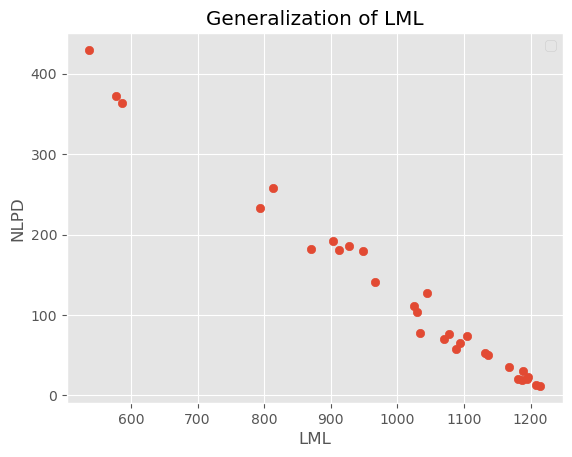

0 -513.215931662987
1 -503.02099603785854
2 -493.96508092030064
3 -485.94880799300023
4 -478.86429573468536
5 -472.5976750547111
6 -467.03158497551664
7 -462.0473734338
8 -457.52675307551857
9 -453.3527164253409
10 -449.4095919734015
11 -445.5822207874719
12 -441.7543646140905
13 -437.80665781972095
14 -433.6147563541047
15 -429.048911408755
16 -423.97705391038966
17 -418.27439806219456
18 -411.84258981272814
19 -404.6384096908441
20 -396.7039351301122
21 -388.17997150724284
22 -379.28520419134327
23 -370.26507994039963
24 -361.33962930642434
25 -352.67692882521885
26 -344.39277514391705
27 -336.56051198414946
28 -329.21884092309443
29 -322.37569309467074
30 -316.0113575161831
31 -310.0833079656088
32 -304.532386002643
33 -299.2883976263946
34 -294.27342450505023
35 -289.4021505610192
36 -284.57921418445966
37 -279.6937894919474
38 -274.61161750754786
39 -269.16512807889194
40 -263.14393599943145
41 -256.29198630928914
42 -248.32477322224656
43 -238.98860406165073
44 -228.1851500445548

C:\Users\Yue\AppData\Local\Temp\ipykernel_11224\237681526.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


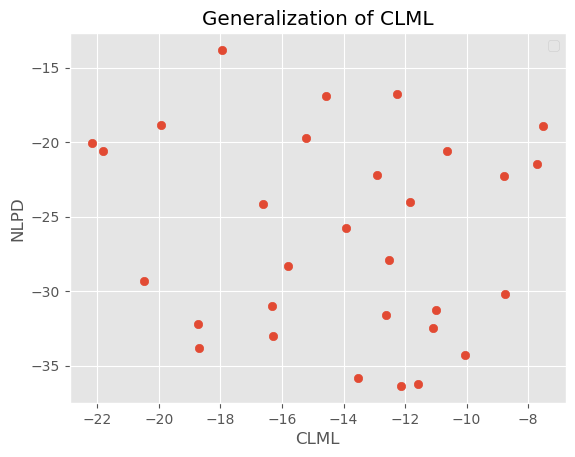

0 -249.37028427123514
1 -236.52697182690625
2 -227.66323991515932
3 -221.6000380752637
4 -217.1684495982449
5 -213.39327894892944
6 -209.49320257632687
7 -204.73932153367133
8 -198.29564760374782
9 -189.309628568342
10 -177.6708183817888
11 -164.7976844896893
12 -152.74744278285323
13 -142.70126882621332
14 -134.4353509078508
15 -126.96102836156038
16 -118.93855925505397
17 -108.28683266141871
18 -92.50119458774773
19 -74.24159053025855
20 -61.189222323928234
21 -51.9836844339588
22 -44.772579124109825
23 -38.90349039307647
24 -33.96938794215488
25 -29.731880154067355
26 -26.104116440417968
27 -23.05940795021266
28 -20.538467576701848
29 -18.440744888682403
30 -16.660981110280844
31 -15.113261050786306
32 -13.73553045611095
33 -12.485526589467383
34 -11.335157357645699
35 -10.265787780347011
36 -9.264876412982886
37 -8.323754875839114
38 -7.43621793476791
39 -6.597636395509738
40 -5.804387582438579
41 -5.053473505240845
42 -4.342253588334472
43 -3.6682566877095155
44 -3.029058456146259

C:\Users\Yue\AppData\Local\Temp\ipykernel_11224\237681526.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


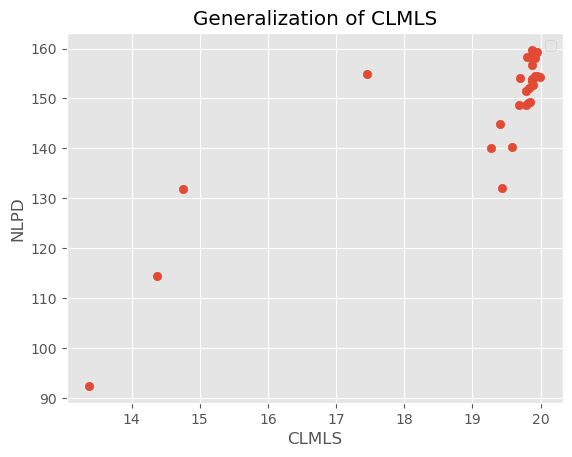

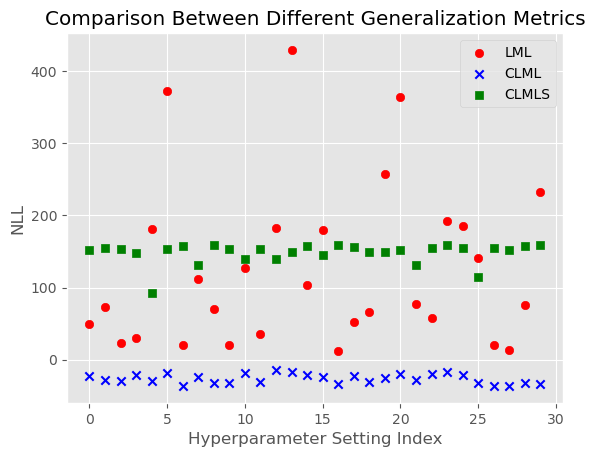

In [11]:
lml_nlpd, lml_opt_hyperparams = lml_exp(hyperparams_inits, T=200, step_size=1e-4)
scatterplot(lml_nlpd, 'LML', 'NLPD', 'Generalization of LML')
clml_nlpd, clml_opt_hyperparams = clml_exp(hyperparams_inits, T=200, step_size=1e-3)
scatterplot(clml_nlpd, 'CLML', 'NLPD', 'Generalization of CLML')
clmls_nlpd, clmls_opt_hyperparams = clmls_exp(hyperparams_inits, T=200, step_size=5e-3)
scatterplot(clmls_nlpd, 'CLMLS', 'NLPD', 'Generalization of CLMLS')
plot_comparision(lml_nlpd[:, 1], clml_nlpd[:, 1], clmls_nlpd[:, 1])

0 -735.5540995877791
1 -498.1505674415082
2 -368.16061040803584
3 -298.8145079053842
4 -250.1515645288846
5 -199.60311906188235
6 -131.07874483784565
7 -26.995028462667165
8 111.74817508093884
9 241.83335261338186
10 339.4486072929385
11 425.9748024525585
12 535.0306888817041
13 689.1181172582155
14 829.3147306967057
15 924.0318055298011
16 993.6352766440133
17 1045.5416805280242
18 1083.673059230304
19 1111.9035786484733
20 1133.5947587719534
21 1151.0438769939067
22 1165.6577652350704
23 1178.2764690613703
24 1189.4109944745767
25 1199.3851314075744
26 1208.4146427550236
27 1216.650985585997
28 1224.2057893246952
29 1231.1649232560187
30 1237.5968467663563
31 1243.5577448894546
32 1249.0948043373262
33 1254.2483800082555
34 1259.0534779746065
35 1263.5408040222674
36 1267.7375278143245
37 1271.6678557872206
38 1275.3534721186802
39 1278.8138864924363
40 1282.066714462968
41 1285.1279079372036
42 1288.0119478774038
43 1290.7320077388024
44 1293.30009374216
45 1295.7271664391176
46 129

C:\Users\Yue\AppData\Local\Temp\ipykernel_11224\237681526.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


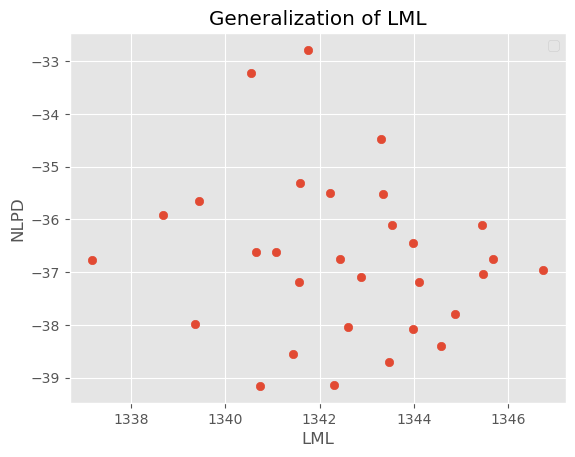

0 -513.215931662987
1 -468.930289011798
2 -447.39641786780373
3 -431.18873633578255
4 -406.5517911276822
5 -365.9000478055091
6 -324.12673486853396
7 -294.1792591272293
8 -269.21529983150094
9 -234.5686926264147
10 -178.26930292002834
11 -135.98635806220813
12 -106.1140616414254
13 -82.85901958732049
14 -66.8970769164394
15 -56.924586878272265
16 -50.278107151541604
17 -45.31539456506343
18 -41.26610670955759
19 -37.79684563375247
20 -34.75309579595765
21 -32.050003776106706
22 -29.631920166673723
23 -27.45748464787141
24 -25.493667218355256
25 -23.713064195984316
26 -22.092482654397855
27 -20.61208888420387
28 -19.25482971557753
29 -18.006000106840986
30 -16.852898406801785
31 -15.78454058148364
32 -14.791418317044645
33 -13.865292248238546
34 -12.999014565929087
35 -12.186376736499966
36 -11.42197885993005
37 -10.701117688668944
38 -10.01969069797272
39 -9.374113912053105
40 -8.761251475248542
41 -8.17835522073068
42 -7.623012731208746
43 -7.093102605190978
44 -6.5867558378354545
45 

C:\Users\Yue\AppData\Local\Temp\ipykernel_11224\237681526.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


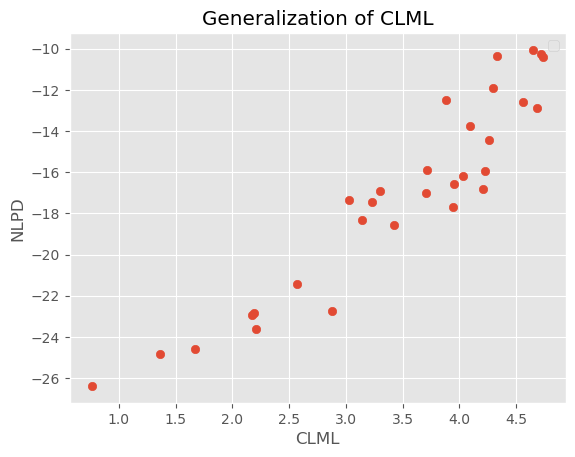

0 -249.37028427123514
1 -230.05416243723047
2 -220.0141122426972
3 -213.98206309558003
4 -208.1151901204389
5 -199.68090569168078
6 -185.72729678168787
7 -166.00880357711827
8 -147.04135360201127
9 -132.9846641334451
10 -120.78928833358961
11 -104.11879620998529
12 -76.85323194945535
13 -56.04487488902488
14 -43.585156263866054
15 -34.719357968949055
16 -27.96396170513644
17 -22.79647979947177
18 -18.995226002841903
19 -16.130160183917667
20 -13.821667824780093
21 -11.851969902084136
22 -10.111596853152292
23 -8.545325449260048
24 -7.122902818634856
25 -5.825590056882163
26 -4.640001967040007
27 -3.5549609594767446
28 -2.5597986502670835
29 -1.6436976031247639
30 -0.7958692594696686
31 -0.006198372994219881
32 0.7340970170687626
33 1.4320962984376422
34 2.0931652435453714
35 2.7212039028738104
36 3.319007786120892
37 3.888628020135428
38 4.431668834831697
39 4.949503241313721
40 5.443412402396518
41 5.9146644574263405
42 6.364550263763562
43 6.794391216442136
44 7.20553074252976
45 7.5

C:\Users\Yue\AppData\Local\Temp\ipykernel_11224\237681526.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


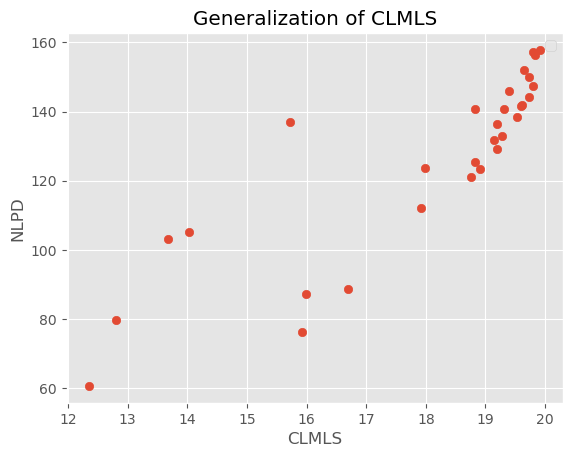

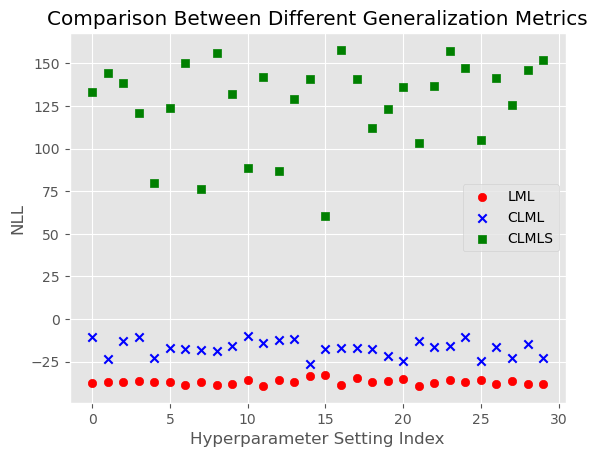

In [12]:
lml_nlpd, lml_opt_hyperparams = lml_exp(hyperparams_inits, T=100, step_size=1e-3)
scatterplot(lml_nlpd, 'LML', 'NLPD', 'Generalization of LML')
clml_nlpd, clml_opt_hyperparams = clml_exp(hyperparams_inits, T=100, step_size=5e-3)
scatterplot(clml_nlpd, 'CLML', 'NLPD', 'Generalization of CLML')
clmls_nlpd, clmls_opt_hyperparams = clmls_exp(hyperparams_inits, T=100, step_size=8e-3)
scatterplot(clmls_nlpd, 'CLMLS', 'NLPD', 'Generalization of CLMLS')
plot_comparision(lml_nlpd[:, 1], clml_nlpd[:, 1], clmls_nlpd[:, 1])

0 -735.5540995877791
1 -498.1505674415082
2 -368.16061040803584
3 -298.8145079053842
4 -250.1515645288846
5 -199.60311906188235
6 -131.07874483784565
7 -26.995028462667165
8 111.74817508093884
9 241.83335261338186
10 339.4486072929385
11 425.9748024525585
12 535.0306888817041
13 689.1181172582155
14 829.3147306967057
15 924.0318055298011
16 993.6352766440133
17 1045.5416805280242
18 1083.673059230304
19 1111.9035786484733
20 1133.5947587719534
21 1151.0438769939067
22 1165.6577652350704
23 1178.2764690613703
24 1189.4109944745767
25 1199.3851314075744
26 1208.4146427550236
27 1216.650985585997
28 1224.2057893246952
29 1231.1649232560187
30 1237.5968467663563
31 1243.5577448894546
32 1249.0948043373262
33 1254.2483800082555
34 1259.0534779746065
35 1263.5408040222674
36 1267.7375278143245
37 1271.6678557872206
38 1275.3534721186802
39 1278.8138864924363
40 1282.066714462968
41 1285.1279079372036
42 1288.0119478774038
43 1290.7320077388024
44 1293.30009374216
45 1295.7271664391176
46 129

C:\Users\Yue\AppData\Local\Temp\ipykernel_11224\237681526.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


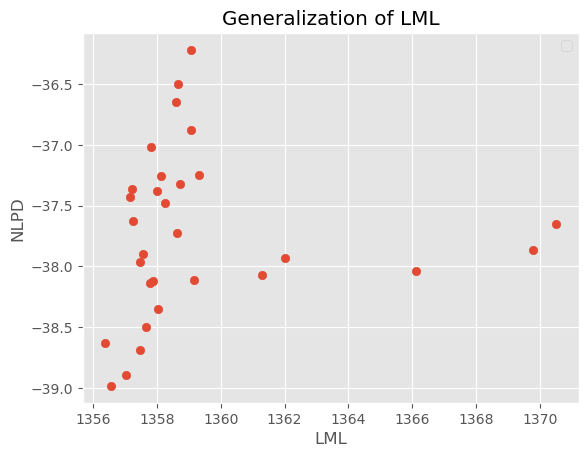

0 -513.215931662987
1 -468.930289011798
2 -447.39641786780373
3 -431.18873633578255
4 -406.5517911276822
5 -365.9000478055091
6 -324.12673486853396
7 -294.1792591272293
8 -269.21529983150094
9 -234.5686926264147
10 -178.26930292002834
11 -135.98635806220813
12 -106.1140616414254
13 -82.85901958732049
14 -66.8970769164394
15 -56.924586878272265
16 -50.278107151541604
17 -45.31539456506343
18 -41.26610670955759
19 -37.79684563375247
20 -34.75309579595765
21 -32.050003776106706
22 -29.631920166673723
23 -27.45748464787141
24 -25.493667218355256
25 -23.713064195984316
26 -22.092482654397855
27 -20.61208888420387
28 -19.25482971557753
29 -18.006000106840986
30 -16.852898406801785
31 -15.78454058148364
32 -14.791418317044645
33 -13.865292248238546
34 -12.999014565929087
35 -12.186376736499966
36 -11.42197885993005
37 -10.701117688668944
38 -10.01969069797272
39 -9.374113912053105
40 -8.761251475248542
41 -8.17835522073068
42 -7.623012731208746
43 -7.093102605190978
44 -6.5867558378354545
45 

C:\Users\Yue\AppData\Local\Temp\ipykernel_11224\237681526.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


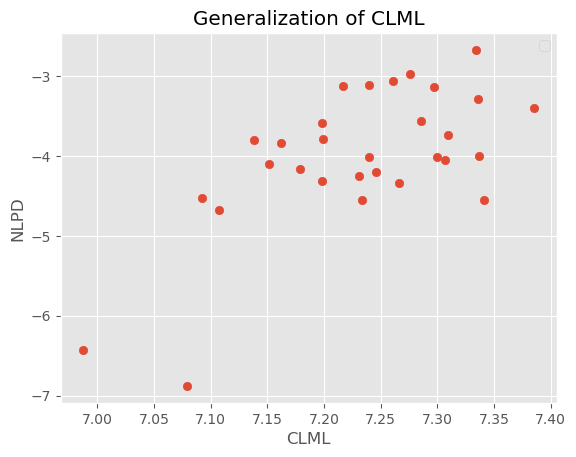

0 -249.37028427123514
1 -230.05416243723047
2 -220.0141122426972
3 -213.98206309558003
4 -208.1151901204389
5 -199.68090569168078
6 -185.72729678168787
7 -166.00880357711827
8 -147.04135360201127
9 -132.9846641334451
10 -120.78928833358961
11 -104.11879620998529
12 -76.85323194945535
13 -56.04487488902488
14 -43.585156263866054
15 -34.719357968949055
16 -27.96396170513644
17 -22.79647979947177
18 -18.995226002841903
19 -16.130160183917667
20 -13.821667824780093
21 -11.851969902084136
22 -10.111596853152292
23 -8.545325449260048
24 -7.122902818634856
25 -5.825590056882163
26 -4.640001967040007
27 -3.5549609594767446
28 -2.5597986502670835
29 -1.6436976031247639
30 -0.7958692594696686
31 -0.006198372994219881
32 0.7340970170687626
33 1.4320962984376422
34 2.0931652435453714
35 2.7212039028738104
36 3.319007786120892
37 3.888628020135428
38 4.431668834831697
39 4.949503241313721
40 5.443412402396518
41 5.9146644574263405
42 6.364550263763562
43 6.794391216442136
44 7.20553074252976
45 7.5

C:\Users\Yue\AppData\Local\Temp\ipykernel_11224\237681526.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


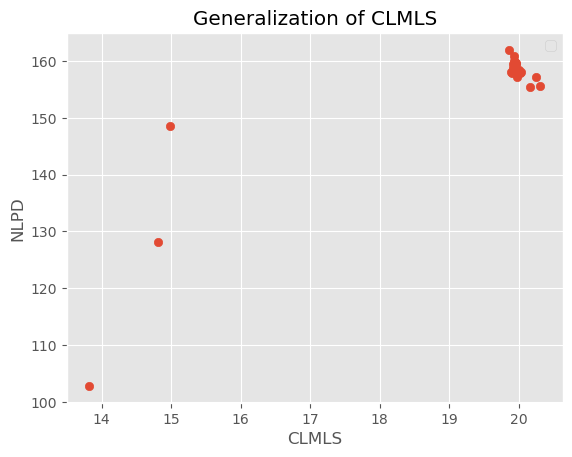

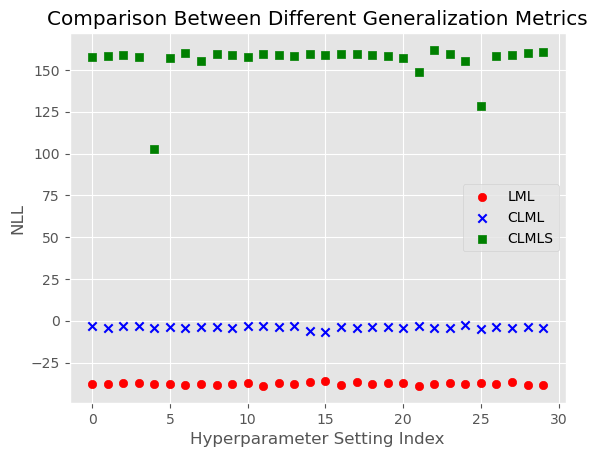

In [13]:
lml_nlpd, lml_opt_hyperparams = lml_exp(hyperparams_inits, T=200, step_size=1e-3)
scatterplot(lml_nlpd, 'LML', 'NLPD', 'Generalization of LML')
clml_nlpd, clml_opt_hyperparams = clml_exp(hyperparams_inits, T=200, step_size=5e-3)
scatterplot(clml_nlpd, 'CLML', 'NLPD', 'Generalization of CLML')
clmls_nlpd, clmls_opt_hyperparams = clmls_exp(hyperparams_inits, T=200, step_size=8e-3)
scatterplot(clmls_nlpd, 'CLMLS', 'NLPD', 'Generalization of CLMLS')
plot_comparision(lml_nlpd[:, 1], clml_nlpd[:, 1], clmls_nlpd[:, 1])

In [14]:
import importlib
import gp
importlib.reload(gp)
from gp import *
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [15]:
unconstrained_hyperparams=inverse_param_transform(hyperparams_inits[0])

clmls_function = conditional_log_marginal_likelihood_sequence(cov_func, X_seq, Y_seq, whole_sequence=True)
clmls_vals=clmls_function(unconstrained_hyperparams)
clmls_vals


Array([-290.04144958, -281.35151801, -268.07823176, -268.05103509,
       -260.14055081, -266.05035311, -248.01394676, -257.75780938,
       -256.56890819], dtype=float64)

-277.2869576124354 3.1018525934666967


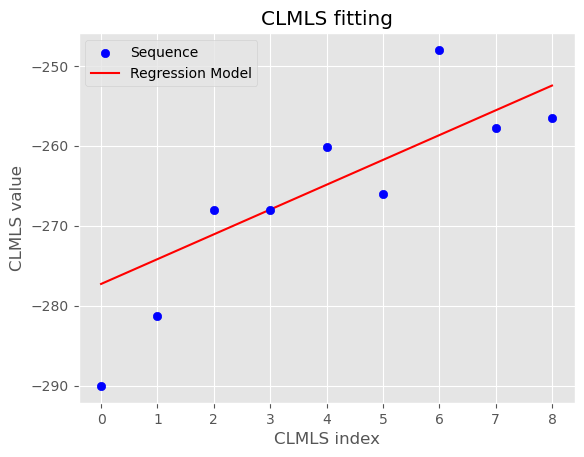

In [16]:
a,b =opt_clmls(clmls_vals)
print(a,b)
x_data = np.arange(len(clmls_vals))
y_data = np.array(clmls_vals)
x_fit = np.linspace(min(x_data), max(x_data), 100)  # Smooth x range for the fitted curve
y_fit = a + b * x_fit

# Plot the data
plt.scatter(x_data, y_data, color='blue', label='Sequence', zorder=5)

# Plot the fitted model
plt.plot(x_fit, y_fit, color='red', label='Regression Model', zorder=4)

# Add labels, legend, and title
plt.xlabel('CLMLS index')
plt.ylabel('CLMLS value')
plt.title('CLMLS fitting')
plt.legend()


In [17]:
# experiment settings

X_train, Y_train, X_test, Y_test = split_train_test(X_whole, Y_whole, num=3000, rate=0.91)
X_con, Y_con = split_clml(X_train, Y_train, ratio=0.8)
X_seq, Y_seq = split_sequence(X_train, Y_train, seq_len=10)

n_trials = 30
cov_func = sqexp_mahalanobis_cov_function
X_star = X_test
hyperparams_inits = []
for i in range(n_trials):
    hyperparams_inits.append(random_init_sqexp_maha_hyperparams(X_train))


0 -892.993910815165
1 -846.3699408451679
2 -802.5305470943974
3 -761.3894414277657
4 -722.8515106524703
5 -686.8133372407515
6 -653.1639073084258
7 -621.7854838570078
8 -592.5546159517884
9 -565.3432486469719
10 -540.0198944354502
11 -516.4508250104877
12 -494.50124223822974
13 -474.0363893527948
14 -454.92256725561504
15 -437.02802607187107
16 -420.2237083636811
17 -404.38382717583283
18 -389.38626897709673
19 -375.1128182115608
20 -361.4492063513293
21 -348.2849939398959
22 -335.51329918033093
23 -323.03039136016093
24 -310.735172180438
25 -298.5285733882481
26 -286.3129056506889
27 -273.9912020942502
28 -261.4666111100578
29 -248.64190747403302
30 -235.41920868879117
31 -221.7000039554806
32 -207.38562400797014
33 -192.3782965003537
34 -176.5829359170898
35 -159.90979791525808
36 -142.27807225833794
37 -123.62038406346892
38 -103.8880158710067
39 -83.05646545488742
40 -61.13075198228444
41 -38.14973344276268
42 -14.188664593872772
43 10.640651428755746
44 36.192489662145135
45 62.29

C:\Users\Yue\AppData\Local\Temp\ipykernel_11224\237681526.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


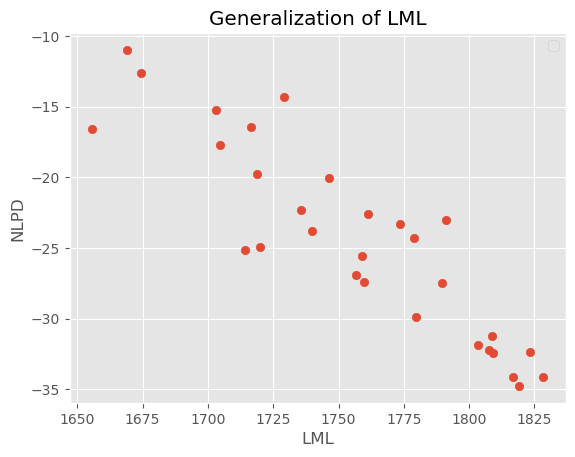

0 -654.9909504688517
1 -640.2535736693812
2 -627.2874625429305
3 -615.9464468063887
4 -606.0688325369388
5 -597.4827595514402
6 -590.0117560340441
7 -583.4799023001383
8 -577.7160762170324
9 -572.5568831660912
10 -567.8480383182405
11 -563.4441318482889
12 -559.2068442260428
13 -555.0017879764853
14 -550.6942655257168
15 -546.1444217119599
16 -541.2026531223573
17 -535.7068669432183
18 -529.4843506482927
19 -522.3623542443435
20 -514.1918046732441
21 -504.8853826984237
22 -494.46232621909706
23 -483.08091694926395
24 -471.0368013972844
25 -458.71909101999984
26 -446.5368334999976
27 -434.8405183852004
28 -423.8644563849929
29 -413.70693871756737
30 -404.34673342761613
31 -395.67830999928856
32 -387.5455431333115
33 -379.76192741799923
34 -372.11462513229037
35 -364.3542056318955
36 -356.1725847079929
37 -347.1726642608603
38 -336.84024365424426
39 -324.54856061505876
40 -309.6571733217231
41 -291.7788956252979
42 -271.2225446636652
43 -249.3880910649791
44 -228.41113407432985
45 -209.7

C:\Users\Yue\AppData\Local\Temp\ipykernel_11224\237681526.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


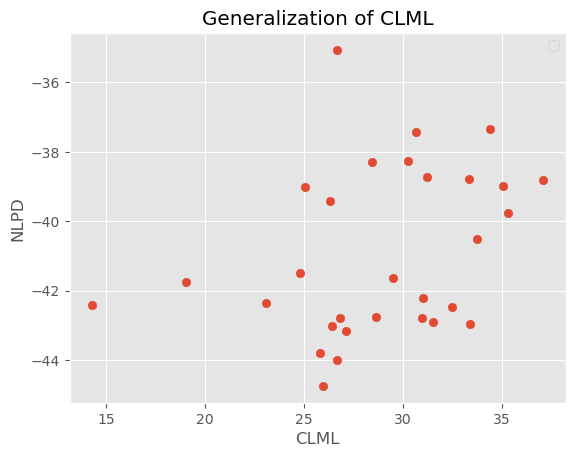

0 -310.3557588441205
1 -304.3359016807497
2 -298.7397321655606
3 -293.55016708615307
4 -288.74708261916834
5 -284.3075052617412
6 -280.2058607454374
7 -276.41426752740205
8 -272.90285866220256
9 -269.6401147228127
10 -266.5931914179852
11 -263.7282290407466
12 -261.01063722528613
13 -258.405358001555
14 -255.87712307328457
15 -253.39073764131825
16 -250.91144233376482
17 -248.40542473065096
18 -245.8405674059652
19 -243.18752026805873
20 -240.4211550751256
21 -237.52237938617685
22 -234.48014264503325
23 -231.2932738696315
24 -227.97161804939003
25 -224.53591184195824
26 -221.01607669113753
27 -217.44809861703283
28 -213.87019205756377
29 -210.31919239662204
30 -206.82792628114652
31 -203.42381872436016
32 -200.12853463545974
33 -196.95824400229492
34 -193.92414331639026
35 -191.03302255371295
36 -188.28780778165657
37 -185.68808241372733
38 -183.23060537380633
39 -180.90983216676918
40 -178.71842839416098
41 -176.6477549945359
42 -174.68830217232676
43 -172.83005272823783
44 -171.0627

C:\Users\Yue\AppData\Local\Temp\ipykernel_11224\237681526.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


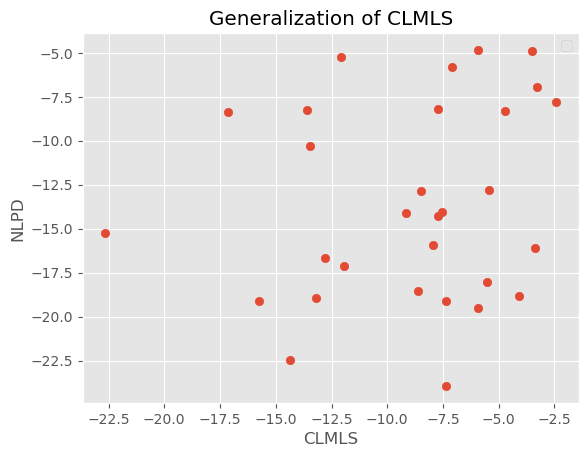

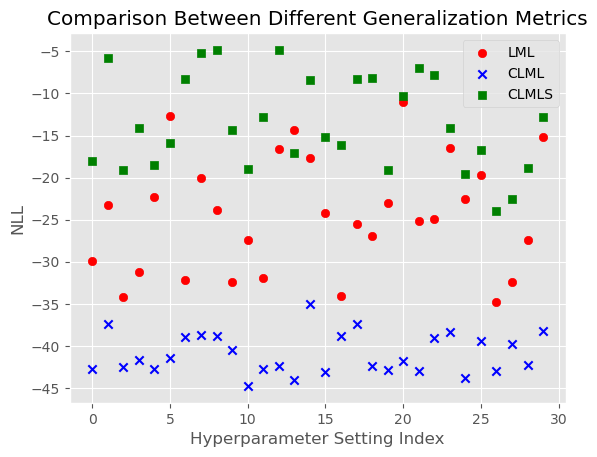

In [18]:
lml_nlpd, lml_opt_hyperparams = lml_exp(hyperparams_inits, T=200, step_size=1e-4)
scatterplot(lml_nlpd, 'LML', 'NLPD', 'Generalization of LML')
clml_nlpd, clml_opt_hyperparams = clml_exp(hyperparams_inits, T=200, step_size=8e-4)
scatterplot(clml_nlpd, 'CLML', 'NLPD', 'Generalization of CLML')
clmls_nlpd, clmls_opt_hyperparams = clmls_exp(hyperparams_inits, T=200, step_size=10e-4)
scatterplot(clmls_nlpd, 'CLMLS', 'NLPD', 'Generalization of CLMLS')
plot_comparision(lml_nlpd[:, 1], clml_nlpd[:, 1], clmls_nlpd[:, 1])

0 -892.993910815165
1 -502.20157396616196
2 -340.8293153515924
3 -242.16188048395748
4 -111.05795612125985
5 104.92742573898522
6 357.6819360189671
7 540.457496973421
8 719.1036712700532
9 1009.851536256997
10 1287.2894746627762
11 1445.1641270951593
12 1545.1627914908725
13 1609.2094465180403
14 1651.8123479881156
15 1683.1103561645086
16 1708.2296080115912
17 1729.4768472359926
18 1747.954788984552
19 1764.2676707168368
20 1778.7978839011853
21 1791.8171158043288
22 1803.5342023297812
23 1814.1176428590143
24 1823.7073656303407
25 1832.421616941671
26 1840.3614460380884
27 1847.6138796329205
28 1854.254304172189
29 1860.3483240660355
30 1865.9532492259173
31 1871.1193078631613
32 1875.890648918944
33 1880.3061794683665
34 1884.4002701678698
35 1888.203353524041
36 1891.7424339816246
37 1895.041524698586
38 1898.1220228577881
39 1901.0030331083742
40 1903.7016470055103
41 1906.2331849707066
42 1908.6114062235956
43 1910.848691269788
44 1912.956200819457
45 1914.9440144240918
46 1916.8

C:\Users\Yue\AppData\Local\Temp\ipykernel_11224\237681526.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


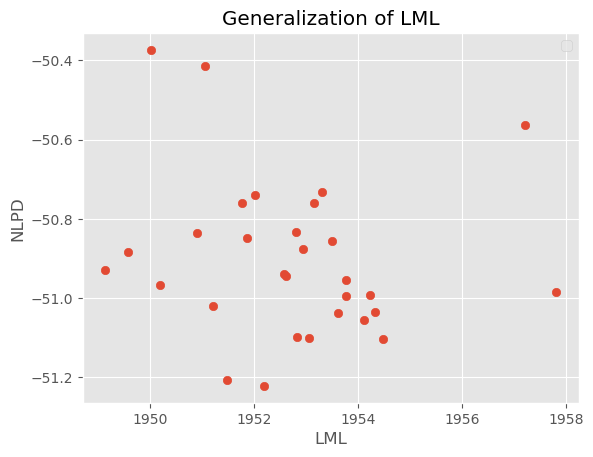

0 -654.9909504688517
1 -563.3238219531456
2 -529.6511709757558
3 -449.4331337177627
4 -342.77217155028893
5 -200.1704059656324
6 -78.50078541652655
7 -24.39917356647311
8 -7.796828461509165
9 -0.326491190388424
10 4.781381975620718
11 8.91405780849044
12 12.410507567647699
13 15.421044641350704
14 18.047064842709858
15 20.361294982150014
16 22.416916339529337
17 24.253522172530154
18 25.901236903844506
19 27.38360925239232
20 28.719635728777973
21 29.925149787017915
22 31.013749447762905
23 31.99739573535743
24 32.886785314625854
25 33.69157572057935
26 34.420520533094134
27 35.081553990615134
28 35.681850517426255
29 36.227874162963474
30 36.72542575237344
31 37.179690950024224
32 37.595289805810694
33 37.976327052565466
34 38.32644196044157
35 38.6488565588665
36 38.94642126442301
37 39.22165725231639
38 39.47679519781161
39 39.713810254601526
40 39.93445331808101
41 40.140278746058584
42 40.33266878648857
43 40.51285500213663
44 40.68193699619923
45 40.84089873864997
46 40.990622777

C:\Users\Yue\AppData\Local\Temp\ipykernel_11224\237681526.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


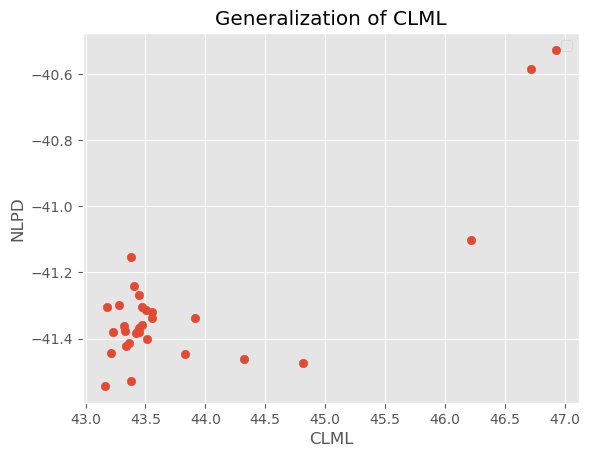

0 -310.3557588441205
1 -262.03228330659516
2 -242.4263564729992
3 -215.23459684748866
4 -182.31610890484842
5 -162.77445807542324
6 -147.6151511004624
7 -118.1121663850007
8 -66.92761266940353
9 -41.54460389177554
10 -28.744413049921278
11 -20.863784075749493
12 -16.601212164914102
13 -13.938586172782209
14 -11.98065261691471
15 -10.427771815518554
16 -9.143225914437863
17 -8.045378009704706
18 -7.079694281274328
19 -6.208563912707831
20 -5.406159058757595
21 -4.655148123489312
22 -3.9443080136015283
23 -3.266718389621616
24 -2.6184047616671933
25 -1.9973422165722923
26 -1.40274212996826
27 -0.8345523154700629
28 -0.2931124102002798
29 0.2210808831335953
30 0.7075321689509053
31 1.1658530510920002
32 1.5958313905045713
33 1.9974748569108272
34 2.371035478452626
35 2.7170190541055774
36 3.036181494775633
37 3.329513316816275
38 3.5982134839184994
39 3.843654320185834
40 4.067339951055743
41 4.270861326738043
42 4.455851105276736
43 4.623941437241882
44 4.7767270691255135
45 4.9157353297

C:\Users\Yue\AppData\Local\Temp\ipykernel_11224\237681526.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


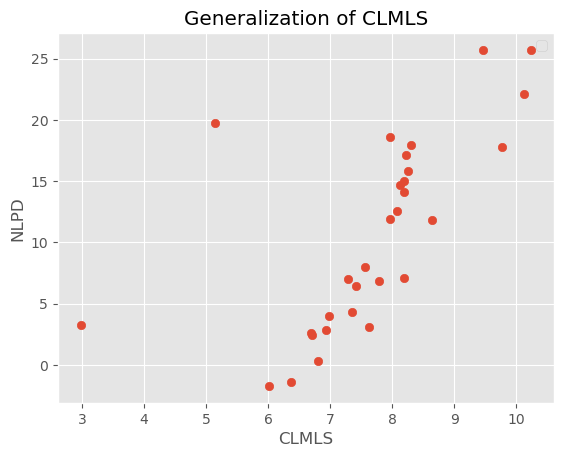

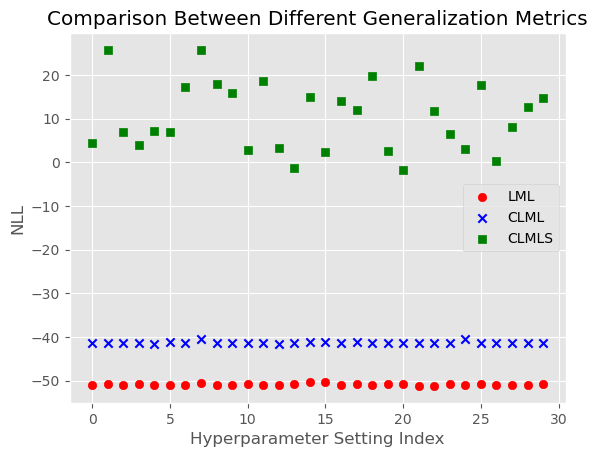

In [19]:
lml_nlpd, lml_opt_hyperparams = lml_exp(hyperparams_inits, T=100, step_size=1e-3)
scatterplot(lml_nlpd, 'LML', 'NLPD', 'Generalization of LML')
clml_nlpd, clml_opt_hyperparams = clml_exp(hyperparams_inits, T=100, step_size=8e-3)
scatterplot(clml_nlpd, 'CLML', 'NLPD', 'Generalization of CLML')
clmls_nlpd, clmls_opt_hyperparams = clmls_exp(hyperparams_inits, T=100, step_size=10e-3)
scatterplot(clmls_nlpd, 'CLMLS', 'NLPD', 'Generalization of CLMLS')
plot_comparision(lml_nlpd[:, 1], clml_nlpd[:, 1], clmls_nlpd[:, 1])

0 -892.993910815165
1 -502.20157396616196
2 -340.8293153515924
3 -242.16188048395748
4 -111.05795612125985
5 104.92742573898522
6 357.6819360189671
7 540.457496973421
8 719.1036712700532
9 1009.851536256997
10 1287.2894746627762
11 1445.1641270951593
12 1545.1627914908725
13 1609.2094465180403
14 1651.8123479881156
15 1683.1103561645086
16 1708.2296080115912
17 1729.4768472359926
18 1747.954788984552
19 1764.2676707168368
20 1778.7978839011853
21 1791.8171158043288
22 1803.5342023297812
23 1814.1176428590143
24 1823.7073656303407
25 1832.421616941671
26 1840.3614460380884
27 1847.6138796329205
28 1854.254304172189
29 1860.3483240660355
30 1865.9532492259173
31 1871.1193078631613
32 1875.890648918944
33 1880.3061794683665
34 1884.4002701678698
35 1888.203353524041
36 1891.7424339816246
37 1895.041524698586
38 1898.1220228577881
39 1901.0030331083742
40 1903.7016470055103
41 1906.2331849707066
42 1908.6114062235956
43 1910.848691269788
44 1912.956200819457
45 1914.9440144240918
46 1916.8

C:\Users\Yue\AppData\Local\Temp\ipykernel_11224\237681526.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


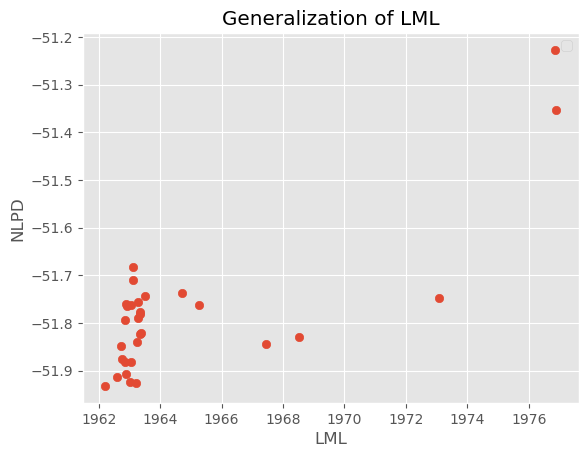

0 -654.9909504688517
1 -563.3238219531456
2 -529.6511709757558
3 -449.4331337177627
4 -342.77217155028893
5 -200.1704059656324
6 -78.50078541652655
7 -24.39917356647311
8 -7.796828461509165
9 -0.326491190388424
10 4.781381975620718
11 8.91405780849044
12 12.410507567647699
13 15.421044641350704
14 18.047064842709858
15 20.361294982150014
16 22.416916339529337
17 24.253522172530154
18 25.901236903844506
19 27.38360925239232
20 28.719635728777973
21 29.925149787017915
22 31.013749447762905
23 31.99739573535743
24 32.886785314625854
25 33.69157572057935
26 34.420520533094134
27 35.081553990615134
28 35.681850517426255
29 36.227874162963474
30 36.72542575237344
31 37.179690950024224
32 37.595289805810694
33 37.976327052565466
34 38.32644196044157
35 38.6488565588665
36 38.94642126442301
37 39.22165725231639
38 39.47679519781161
39 39.713810254601526
40 39.93445331808101
41 40.140278746058584
42 40.33266878648857
43 40.51285500213663
44 40.68193699619923
45 40.84089873864997
46 40.990622777

C:\Users\Yue\AppData\Local\Temp\ipykernel_11224\237681526.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


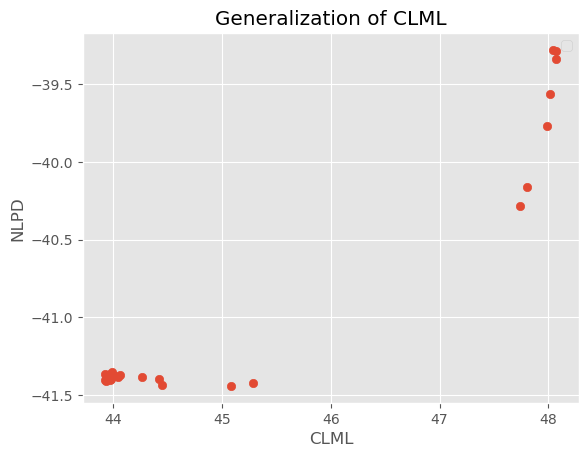

0 -310.3557588441205
1 -262.03228330659516
2 -242.4263564729992
3 -215.23459684748866
4 -182.31610890484842
5 -162.77445807542324
6 -147.6151511004624
7 -118.1121663850007
8 -66.92761266940353
9 -41.54460389177554
10 -28.744413049921278
11 -20.863784075749493
12 -16.601212164914102
13 -13.938586172782209
14 -11.98065261691471
15 -10.427771815518554
16 -9.143225914437863
17 -8.045378009704706
18 -7.079694281274328
19 -6.208563912707831
20 -5.406159058757595
21 -4.655148123489312
22 -3.9443080136015283
23 -3.266718389621616
24 -2.6184047616671933
25 -1.9973422165722923
26 -1.40274212996826
27 -0.8345523154700629
28 -0.2931124102002798
29 0.2210808831335953
30 0.7075321689509053
31 1.1658530510920002
32 1.5958313905045713
33 1.9974748569108272
34 2.371035478452626
35 2.7170190541055774
36 3.036181494775633
37 3.329513316816275
38 3.5982134839184994
39 3.843654320185834
40 4.067339951055743
41 4.270861326738043
42 4.455851105276736
43 4.623941437241882
44 4.7767270691255135
45 4.9157353297

C:\Users\Yue\AppData\Local\Temp\ipykernel_11224\237681526.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


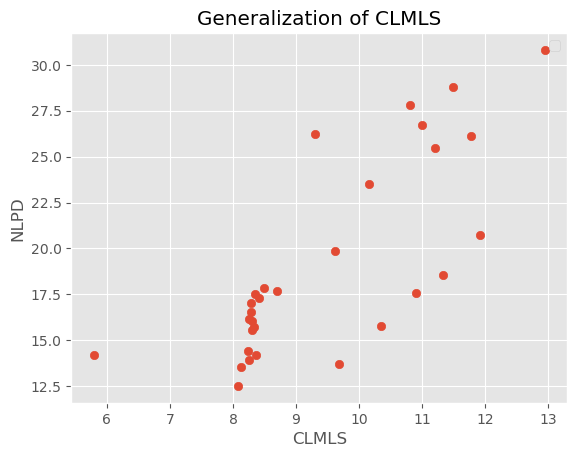

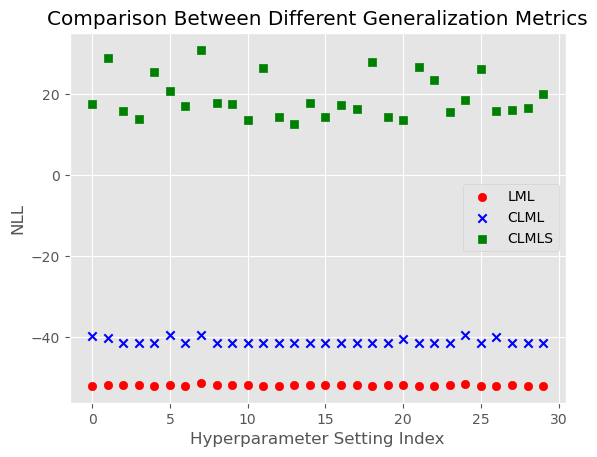

In [20]:
lml_nlpd, lml_opt_hyperparams = lml_exp(hyperparams_inits, T=200, step_size=1e-3)
scatterplot(lml_nlpd, 'LML', 'NLPD', 'Generalization of LML')
clml_nlpd, clml_opt_hyperparams = clml_exp(hyperparams_inits, T=200, step_size=8e-3)
scatterplot(clml_nlpd, 'CLML', 'NLPD', 'Generalization of CLML')
clmls_nlpd, clmls_opt_hyperparams = clmls_exp(hyperparams_inits, T=200, step_size=10e-3)
scatterplot(clmls_nlpd, 'CLMLS', 'NLPD', 'Generalization of CLMLS')
plot_comparision(lml_nlpd[:, 1], clml_nlpd[:, 1], clmls_nlpd[:, 1])

In [21]:
unconstrained_hyperparams=inverse_param_transform(hyperparams_inits[0])

clmls_function = conditional_log_marginal_likelihood_sequence(cov_func, X_seq, Y_seq, whole_sequence=True)
clmls_vals=clmls_function(unconstrained_hyperparams)
clmls_vals


Array([-364.28808926, -355.02489619, -350.47509347, -345.91103631,
       -332.2293606 , -334.83418829, -316.01128321, -322.18185738,
       -320.26706386], dtype=float64)

-358.65507747753605 5.366590959268398


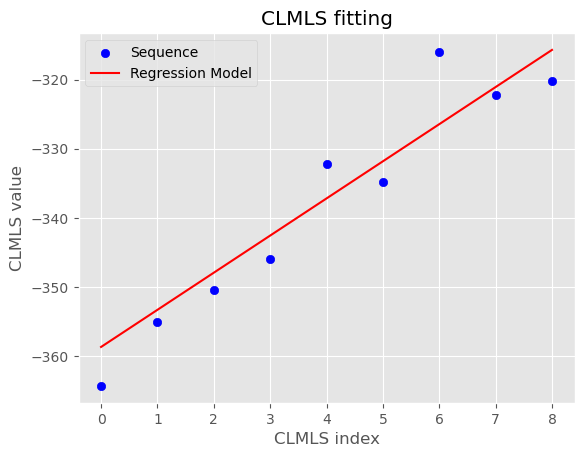

In [22]:
a,b =opt_clmls(clmls_vals)
print(a,b)
x_data = np.arange(len(clmls_vals))
y_data = np.array(clmls_vals)
x_fit = np.linspace(min(x_data), max(x_data), 100)  # Smooth x range for the fitted curve
y_fit = a + b * x_fit

# Plot the data
plt.scatter(x_data, y_data, color='blue', label='Sequence', zorder=5)

# Plot the fitted model
plt.plot(x_fit, y_fit, color='red', label='Regression Model', zorder=4)

# Add labels, legend, and title
plt.xlabel('CLMLS index')
plt.ylabel('CLMLS value')
plt.title('CLMLS fitting')
plt.legend()
